# updates
- ver 0.1
    - 学習できることを確認
    - 1epochごとにモデルを保存できるように変更
- ver 0.2
    - embNetを並列化

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
from numba import jit
from tqdm import tqdm

%matplotlib inline

現状GPUメモリに乗りきらずCPUで回している<br>
VGGの出力をあらかじめpickleとして保存することで回避可能か？

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
import keras

/home/inouelab/.conda/envs/zukapy35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator

In [21]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input,Layer,Lambda
from keras.layers import Flatten,BatchNormalization
from keras.layers import Dense,Dropout
from keras.layers import concatenate
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras import backend as K

In [6]:
imheight = 128
imwidth = 128
channels = 3
# ALPHA = 0.2
ALPHA=0.05
dense_num = 100

In [7]:
from keras.applications.vgg16 import VGG16
#include_top=false => Dense不要
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=Input(shape=(imwidth, imheight, channels)), input_shape=None) 

In [8]:
for layer in base_model.layers[:15]:
    layer.trainable=False

In [78]:
# shallow network for colorized features
# create_embNetの中でやるべき？
inputs = Input(shape=(imwidth, imheight, channels))
conv1 = Conv2D(32, (4,4) , padding='same', activation='relu')(inputs)
pool1 = MaxPooling2D(pool_size=(2,2), strides=None, padding='valid')(conv1)
conv2 = Conv2D(32, (4,4) , padding='same', activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2,2), strides=None, padding='valid')(conv2)
flatten = Flatten()(pool2) 
dense_layer = Dense(dense_num, activation='relu')(flatten)
norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer1')(dense_layer)
shallow_model=Model(inputs=inputs,outputs=norm_layer) 

In [61]:
def create_embNet():
    shallow_inputs = Input(shape=(imwidth, imheight, channels))
    x = base_model.output
    conv1 = Conv2D(32, (4,4) , padding='same', activation='relu')(x)
    conv2 = Conv2D(32, (4,4) , padding='same', activation='relu')(conv1)
    flatten = Flatten()(conv2) 
    dense_layer = Dense(dense_num/2, activation='relu')(flatten)
    norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)
    # inputに対してshallow_modelのoutputも用意
    x1 = norm_layer
    x2 = shallow_model(shallow_inputs)
    out = concatenate([norm_layer,x2])
    return Model(inputs=[base_model.input,shallow_inputs],outputs=out)
#     return  Model(inputs=[base_model.input], outputs=norm_layer)

In [62]:
# define three Inputs
# create embNetの中でInputを定義すると明示的に3つの入力が分けられない
a_in = Input(shape = (imheight, imwidth, channels), name='anchor_input')
p_in = Input(shape = (imheight, imwidth, channels), name='positive_input')
n_in = Input(shape = (imheight, imwidth, channels), name='negative_input')

In [67]:
sa_in = Input(shape = (imheight, imwidth, channels), name='sanchor_input')

In [63]:
# 学習後にベクトルのencoderとして利用するので外に定義する。
con_embNet = create_embNet()
shop_embNet = create_embNet()

In [72]:
a_emb = shop_embNet([a_in,a_in])
p_emb = con_embNet([p_in,p_in])
n_emb = con_embNet([n_in,n_in])

In [73]:
class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss
    
    def get_config(self):
        config = {'alpha': self.alpha}
        base_config = super(TripletLossLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [74]:
# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=ALPHA, name='triplet_loss_layer')([a_emb, p_emb, n_emb])

# Model that can be trained with anchor, positive negative images
tripletNet = Model([a_in, p_in, n_in], triplet_loss_layer)

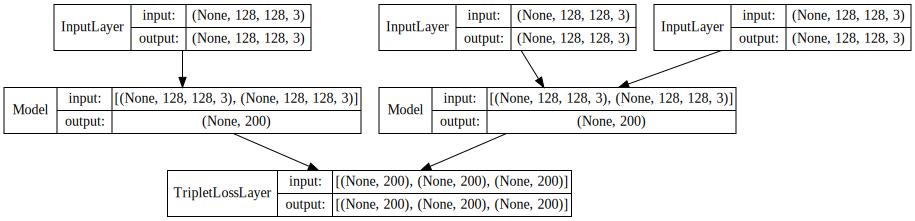

In [75]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(tripletNet, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

In [79]:
#並列化
# from keras.utils import multi_gpu_model
# tripletNet2 = multi_gpu_model(tripletNet,gpus=2)
# compile model
tripletNet.compile(loss=None, optimizer='adam')

### データの用意

In [80]:
import os

BASE_PATH = './dataset/T_Shirt_all/'
ids = sorted([x for x in os.listdir(BASE_PATH)])

In [17]:
ids[0]

'id_00000001'

In [18]:
len(ids)

6155

### tripletのパスの組を返す関数

In [81]:
import itertools
import random

# @jit
def get_triplets(ids,BASE_PATH):
    triplets=[]
    # idの選択の仕方をランダムにしたらいいのか？
    for id_ in tqdm(ids):
        files = sorted([BASE_PATH+id_+'/'+x for x in os.listdir(BASE_PATH+id_)])
#         print(files)
        con = sorted([x for x in files if 'comsumer' in x])
        shop = sorted([x for x in files if 'shop' in x ])
        combs = list(itertools.product(tuple(con),tuple(shop)))
        
        for comb in combs:
#             print(len(comb))
            comb = list(comb)
            neg_id = random.choice([x for x in ids if x != id_])
#             print(neg_id)
#             print(len([BASE_PATH+neg_id+'/'+x for x in os.listdir(BASE_PATH+neg_id) if 'shop' in x]))
            neg_file = random.choice([BASE_PATH+neg_id+'/'+x for x in os.listdir(BASE_PATH+neg_id) if 'shop' in x])
            comb.append(neg_file)
            triplets.append(comb)
    
    return triplets

### id単位でtrainとtestを分割する
- 元々np.random.choice()でやっていたが、ブートストラップサンプリングだったのでダメ
- train_test_splitを利用

In [82]:
from sklearn.cross_validation import train_test_split
# from sklearn.model_selection import ShuffleSplit

/home/inouelab/.conda/envs/zukapy35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [83]:
# random_stateを固定しておく
train_ids,test_ids=train_test_split(ids,test_size=0.33,random_state=0)

In [84]:
train_ids[:5]

['id_00016780', 'id_00007427', 'id_00029554', 'id_00020254', 'id_00018517']

In [85]:
from PIL import Image
# @jit
def get_np_triplets(triplet_PATHs):
    triplets = []
    # triplets = np.ndarray
    for triplet in tqdm(triplet_PATHs):

#         anc_img = Image.fromarray(np.uint8(triplet[0])).convert('RGB')
#         pos_img = Image.fromarray(np.uint8(triplet[1])).convert('RGB')
#         neg_img = Image.fromarray(np.uint8(triplet[2])).convert('RGB')

        anc_img = Image.open(triplet[0]).convert('RGB')
        pos_img = Image.open(triplet[1]).convert('RGB')
        neg_img = Image.open(triplet[2]).convert('RGB')

        anc_img = np.array(anc_img.resize((128,128)))/255. #resize to (128,128,3)
        pos_img = np.array(pos_img.resize((128,128)))/255.    
        neg_img = np.array(neg_img.resize((128,128)))/255.    

        tri = [anc_img,pos_img,neg_img]
        triplets.append(np.array(tri))

    triplets = np.array(triplets)
    return triplets

test_idsはretrival.ipynbで参照するのでpickleとして保存

In [86]:
import pickle
f = open('test_ids.txt', 'wb')
pickle.dump(test_ids, f)

In [87]:
epochs = 30

各エポックでtestデータを用いてN-top accを出したい→けど結果としてはいらない？
- epochの外でtrain,testに分割するパターンなので常にtestのidは同じ
- train_tripletのnegativeが毎回ランダムになるので偏らないメリットがある
- model.fitはepochs=1で行う

In [ ]:
for epoch in range(epochs):
    print('epoch %s'% epoch)
    # PATHの組みを取得
    triplets_train_PATHs = get_triplets(train_ids,BASE_PATH)
    # np配列に変換
    triplets = get_np_triplets(triplets_train_PATHs)
    # fit
    tripletNet.fit([triplets[:,0],triplets[:,1],triplets[:,2]], epochs=1, batch_size=50) # using batch_size is better
    
    if epoch % 5 == 0 and epoch != 0:
#         tripletNet.save('./model/T_Shirt/krasser/tripletNetmodel_e{}.h5'.format(epoch))
#         # 5epochごとにmodelを保存
#         shop_embNet.save('./model/T_Shirt/krasser/shop_emb_e{}.h5'.format(epoch))
#         con_embNet.save('./model/T_Shirt/krasser/con_emb_e{}.h5'.format(epoch))
        
        tripletNet.save('./model/T_Shirt/test/tripletNetmodel200_e{}.h5'.format(epoch))
        # 5epochごとにmodelを保存
        shop_embNet.save('./model/T_Shirt/test/shop_emb200_e{}.h5'.format(epoch))
        con_embNet.save('./model/T_Shirt/test/con_emb200_e{}.h5'.format(epoch))


  0%|          | 19/4123 [00:00<00:22, 183.97it/s]

epoch 0


100%|██████████| 38378/38378 [01:46<00:00, 359.18it/s]


Epoch 1/1
38378/38378 [==============================] - 3140s 82ms/step - loss: 1.6444


  1%|          | 21/4123 [00:00<00:21, 188.31it/s]

epoch 1


100%|██████████| 38378/38378 [02:00<00:00, 317.42it/s]


Epoch 1/1
38378/38378 [==============================] - 3137s 82ms/step - loss: 1.0428


  0%|          | 14/4123 [00:00<00:29, 139.73it/s]

epoch 2


100%|██████████| 38378/38378 [01:46<00:00, 360.16it/s]


Epoch 1/1
38378/38378 [==============================] - 3133s 82ms/step - loss: 0.7908


  1%|          | 21/4123 [00:00<00:21, 192.54it/s]

epoch 3


100%|██████████| 38378/38378 [01:46<00:00, 359.77it/s]


Epoch 1/1
38378/38378 [==============================] - 3131s 82ms/step - loss: 0.6322


  0%|          | 19/4123 [00:00<00:24, 170.03it/s]

epoch 4


100%|██████████| 38378/38378 [01:47<00:00, 358.33it/s]


Epoch 1/1
38378/38378 [==============================] - 3137s 82ms/step - loss: 0.5395


  0%|          | 19/4123 [00:00<00:26, 154.93it/s]

epoch 5


100%|██████████| 38378/38378 [01:47<00:00, 358.42it/s]


Epoch 1/1
38378/38378 [==============================] - 3132s 82ms/step - loss: 0.4659


  0%|          | 19/4123 [00:00<00:22, 179.84it/s]

epoch 6


100%|██████████| 38378/38378 [01:49<00:00, 352.02it/s]


Epoch 1/1
38378/38378 [==============================] - 3134s 82ms/step - loss: 0.4078


  0%|          | 19/4123 [00:00<00:24, 169.24it/s]

epoch 7


100%|██████████| 38378/38378 [01:48<00:00, 355.13it/s]


Epoch 1/1
38378/38378 [==============================] - 3167s 83ms/step - loss: 0.3524


  1%|          | 44/4123 [00:00<00:09, 438.88it/s]

epoch 8


100%|██████████| 38378/38378 [01:48<00:00, 355.09it/s]


Epoch 1/1
38378/38378 [==============================] - 3133s 82ms/step - loss: 0.3122


  0%|          | 19/4123 [00:00<00:23, 177.57it/s]

epoch 9


100%|██████████| 38378/38378 [01:48<00:00, 355.19it/s]


Epoch 1/1
38378/38378 [==============================] - 3136s 82ms/step - loss: 0.2818


  0%|          | 19/4123 [00:00<00:22, 183.48it/s]

epoch 10


100%|██████████| 38378/38378 [01:48<00:00, 354.23it/s]


Epoch 1/1
38378/38378 [==============================] - 3139s 82ms/step - loss: 0.2599


  1%|          | 27/4123 [00:00<00:16, 245.35it/s]

epoch 11


100%|██████████| 38378/38378 [01:48<00:00, 352.13it/s]


Epoch 1/1
38378/38378 [==============================] - 3138s 82ms/step - loss: 0.2263


  0%|          | 19/4123 [00:00<00:21, 188.87it/s]

epoch 12


100%|██████████| 38378/38378 [01:48<00:00, 354.19it/s]


Epoch 1/1
38378/38378 [==============================] - 3135s 82ms/step - loss: 0.2037


  0%|          | 19/4123 [00:00<00:23, 173.66it/s]

epoch 13


100%|██████████| 38378/38378 [01:48<00:00, 354.60it/s]


Epoch 1/1
38378/38378 [==============================] - 3136s 82ms/step - loss: 0.1817


  1%|          | 21/4123 [00:00<00:20, 204.46it/s]

epoch 14


100%|██████████| 38378/38378 [01:48<00:00, 354.93it/s]


Epoch 1/1
38378/38378 [==============================] - 3135s 82ms/step - loss: 0.1778


  0%|          | 19/4123 [00:00<00:24, 169.99it/s]

epoch 15


100%|██████████| 38378/38378 [01:48<00:00, 355.08it/s]


Epoch 1/1
38378/38378 [==============================] - 3136s 82ms/step - loss: 0.1601


  0%|          | 19/4123 [00:00<00:22, 185.27it/s]

epoch 16


100%|██████████| 38378/38378 [01:49<00:00, 351.81it/s]


Epoch 1/1
38378/38378 [==============================] - 3136s 82ms/step - loss: 0.1451


  0%|          | 19/4123 [00:00<00:25, 159.19it/s]

epoch 17


100%|██████████| 38378/38378 [01:48<00:00, 354.80it/s]


Epoch 1/1
38378/38378 [==============================] - 3134s 82ms/step - loss: 0.1347


  0%|          | 19/4123 [00:00<00:22, 178.70it/s]

epoch 18


100%|██████████| 38378/38378 [01:48<00:00, 354.75it/s]


Epoch 1/1
38378/38378 [==============================] - 3134s 82ms/step - loss: 0.1259


  0%|          | 19/4123 [00:00<00:25, 161.36it/s]

epoch 19


100%|██████████| 38378/38378 [01:48<00:00, 355.27it/s]


Epoch 1/1
38378/38378 [==============================] - 3137s 82ms/step - loss: 0.1239


  0%|          | 19/4123 [00:00<00:23, 174.86it/s]

epoch 20


100%|██████████| 38378/38378 [01:48<00:00, 354.73it/s]


Epoch 1/1
38378/38378 [==============================] - 3135s 82ms/step - loss: 0.1059


  0%|          | 19/4123 [00:00<00:24, 167.45it/s]

epoch 21


100%|██████████| 38378/38378 [01:48<00:00, 352.17it/s]


Epoch 1/1
38378/38378 [==============================] - 3135s 82ms/step - loss: 0.1140


  0%|          | 19/4123 [00:00<00:25, 158.25it/s]

epoch 22


100%|██████████| 38378/38378 [01:48<00:00, 354.29it/s]


Epoch 1/1
38378/38378 [==============================] - 3137s 82ms/step - loss: 0.1056


  0%|          | 19/4123 [00:00<00:24, 168.24it/s]

epoch 23


100%|██████████| 38378/38378 [01:48<00:00, 354.91it/s]


Epoch 1/1
38378/38378 [==============================] - 3134s 82ms/step - loss: 0.0986


  0%|          | 19/4123 [00:00<00:25, 160.16it/s]

epoch 24


100%|██████████| 38378/38378 [01:48<00:00, 354.56it/s]


Epoch 1/1
22600/38378 [================>.............] - ETA: 21:29 - loss: 0.0943

In [28]:
len(test_ids)

2032

In [32]:
sum_ = 0
for id_ in tqdm(test_ids):
    files = sorted([BASE_PATH+id_+'/'+x for x in os.listdir(BASE_PATH+id_)])
    sum_+=len(files)

100%|██████████| 2032/2032 [00:00<00:00, 4122.24it/s]


In [31]:
sum_

26290

100%|██████████| 17/17 [00:00<00:00, 230.63it/s]


[['./T_Shirt_all/id_00016780/comsumer_01.jpg', './T_Shirt_all/id_00016780/shop_01.jpg', './T_Shirt_all/id_00007427/shop_01.jpg'], ['./T_Shirt_all/id_00007427/comsumer_01.jpg', './T_Shirt_all/id_00007427/shop_01.jpg', './T_Shirt_all/id_00018517/shop_01.jpg'], ['./T_Shirt_all/id_00029554/comsumer_01.jpg', './T_Shirt_all/id_00029554/shop_01.jpg', './T_Shirt_all/id_00020254/shop_01.jpg'], ['./T_Shirt_all/id_00029554/comsumer_02.jpg', './T_Shirt_all/id_00029554/shop_01.jpg', './T_Shirt_all/id_00016780/shop_01.jpg'], ['./T_Shirt_all/id_00029554/comsumer_03.jpg', './T_Shirt_all/id_00029554/shop_01.jpg', './T_Shirt_all/id_00007427/shop_01.jpg'], ['./T_Shirt_all/id_00029554/comsumer_04.jpg', './T_Shirt_all/id_00029554/shop_01.jpg', './T_Shirt_all/id_00007427/shop_01.jpg'], ['./T_Shirt_all/id_00029554/comsumer_05.jpg', './T_Shirt_all/id_00029554/shop_01.jpg', './T_Shirt_all/id_00007427/shop_01.jpg'], ['./T_Shirt_all/id_00029554/comsumer_06.jpg', './T_Shirt_all/id_00029554/shop_01.jpg', './T_Shir

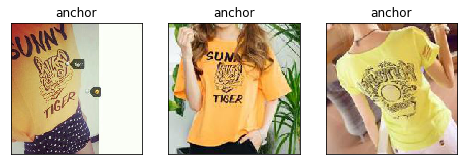

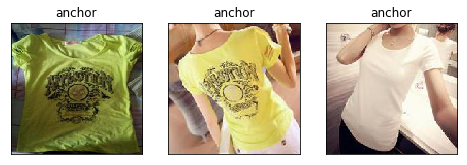

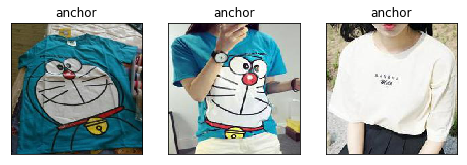

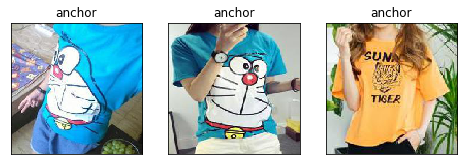

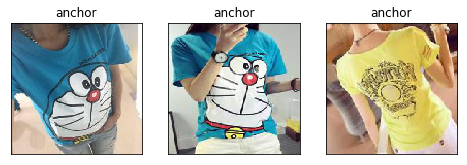

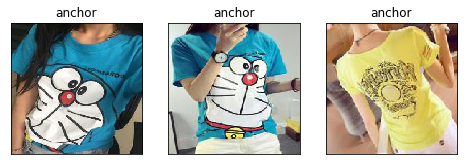

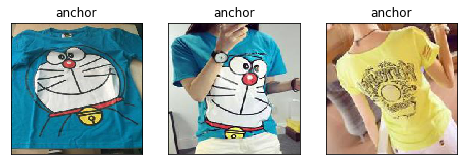

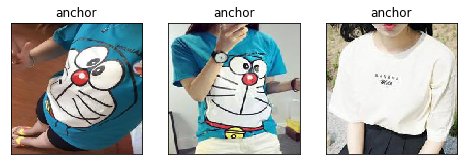

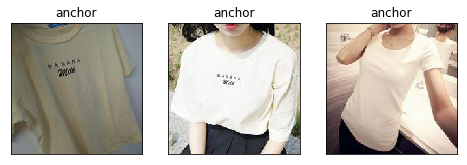

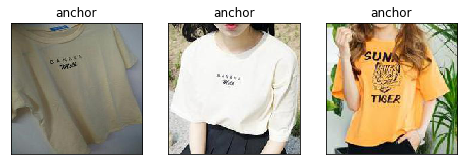

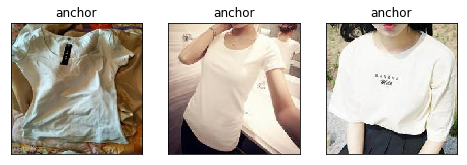

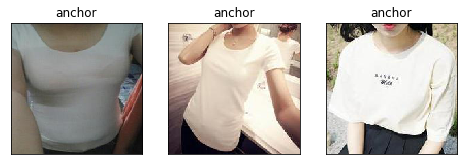

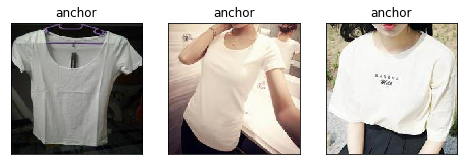

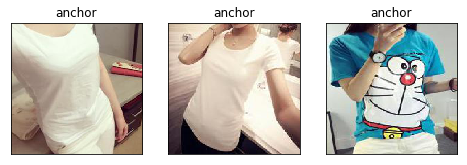

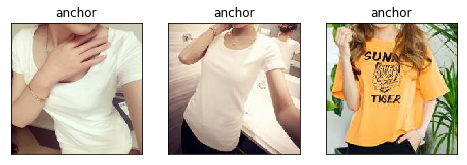

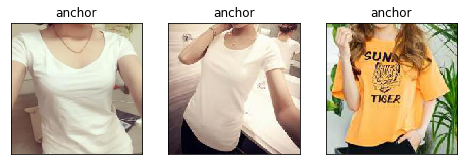

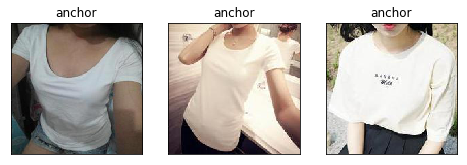

In [45]:
aaa = get_triplets(train_ids[:5],BASE_PATH)
print(aaa)
bbb = get_np_triplets(aaa)

for b in bbb:
#     print(b)
    fig = plt.figure(figsize=(8,4))

    plt.subplot(1,3,1)
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.tick_params(color='white')
    plt.imshow(b[0])
    plt.title('anchor')
    
    plt.subplot(1,3,2)
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.tick_params(color='white')    

    plt.imshow(b[1])
    plt.title('anchor')
    plt.subplot(1,3,3)
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.tick_params(color='white')
    plt.imshow(b[2])
    plt.title('anchor')    
    